# iCAT Import Data to render
---
Overview and interactive walkthrough of how to import image data into `render-ws` via `render-python`.

There are 2 key concepts to keep in mind when importing data to `render-ws`
1. All input data is contained in "tile specifications". So our job is to fill in the tile specification as neatly as possible.
2. Tiles are rendered according to their alpha-numeric tileId. That is, `aaa-tile-00x00` is rendered on top of `zzz-tile-36x48`. In general, we would like to have tiles sorted chronologically such that the tile that was acquired later in time will always appear on top.
3. It is simplest if we import data one stack at a time.

Below is a table summarizing the parameters needed for a [TileSpec](https://github.com/fcollman/render-python/blob/master/renderapi/tilespec.py#L17) object.

| Field    | Type     | Default | Description                                |
| -----    | ----     | ------- | -----------                                |
| tileId   | str      | None    | Unique string specifying a tile's identity |
| z        | float    | None    | z values this tile exists within           |
| width    | int      | None    | Width in pixels of the raw tile            |
| height   | int      | None    | Height in pixels of the raw tile           |
| imageUrl | str      | None    | An image path URI                          |
| maskUrl  | str      | None    | An image path for an alpha mask            |
| minint   | int      | 0       | Pixel intensity value to display as black  |
| maxint   | int      | 65535   | Pixel intensity value to display as white  |
| layout   | `Layout` | None    | a `Layout` object for this tile            |
| tforms   | list     | [ ]     | Transform objects                          |

And because a `TileSpec` requires a `Layout`, below is a table summarizing the parameters needed for a [Layout](https://github.com/fcollman/render-python/blob/master/renderapi/layout.py#L1) object.

| Field     | Type  | Default | Description                                  |
| -----     | ----  | ------- | -----------                                  |
| sectionId | str   | None    | sectionId this tile was taken from           |
| scopeId   | str   | None    | What microscope this came from               |
| cameraId  | str   | None    | Camera this was taken with                   |
| imageRow  | int   | None    | Row from a row,col layout this was taken     |
| imageCol  | int   | None    | Column from a row,col layout this was taken  |
| stageX    | float | None    | X stage coordinates for where this was taken |
| stageY    | float | None    | Y stage coordinates for where this was taken |
| rotation  | float | None    | Angle of camera when this was taken          |
| pixelsize | float | None    | Effective size of pixels                     |

So the game plan will be to build up layouts and tile specifications from metadata and apriori knowledge we have our of our image data. Then we will import the tile specifications into `render-ws` using the appropriate `render-python` method.

## 1 Build Up DataFrames of All Tile Data for Each Stack
---
### 1.0 Import Necessary Packages

In [1]:
import re
from pathlib import Path
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as Soup
from skimage.io import imread
from skimage.external.tifffile import TiffFile

import renderapi
from renderapi.tilespec import TileSpec
from renderapi.layout import Layout
from renderapi.transform import AffineModel

### 1.1 Infer Stacks and Tiles from Project Directory Tree
Assumes that the project directory structure resembles
```
iCAT_demo
    ├───┬ amylase
    │   └─── amylase-00000x00000.ome.tif
    ├───┬ big_EM
    │   └──── big_EM-00000x00000.ome.tif
    ├───┬ hoechst
    │   └──── hoechst-00000x00000.ome.tif
    ├───┬ insulin
    │   └──── insulin-00000x00000.ome.tif
    └───┬ lil_EM
        ├──── lil_EM-00008x00011.ome.tif
        ├──── lil_EM-00008x00012.ome.tif
        ├──── ...
        ├──── lil_EM-00012x00015.ome.tif
        └──── lil_EM-00012x00016.ome.tif
```

In [2]:
owner = 'rlane'  # replace with your name
project = 'iCAT_import'

project_dir = Path('//long_term_storage/rlane/SECOM/iCAT_sample_data')
stacks = [stack_dir.name for stack_dir in project_dir.iterdir()]
tile_fns = {}
for stack in stacks:
    stack_tile_fns = project_dir.joinpath(stack).glob('*.tif')
    tile_fns[stack] = list(stack_tile_fns)

### 1.2 Parse Metadata

In [3]:
def parse_metadata(tile_fn):
    """
    Parses metadata from image tile using TiffFile package and BeautifulSoup
    
    Parameters
    ----------
    tile_fn : `pathlib.Path`
        Path to tile storage location in `pathlib.Path` representation
        
    Returns
    -------
    d : dict
        Almighty dictionary containing lots of juicy info about the tile
    """
    # Gather metadata
    tif = TiffFile(tile_fn.as_posix())
    page = tif.pages[0]
    xml = page.tags['image_description'].value
    metadata = Soup(xml, 'lxml')
    
    # Parse metadata for scope and camera IDs
    instrument_data = metadata.find('instrument').attrs
    detector_data = metadata.find('detector').attrs
    scopeId = instrument_data['id']
    cameraId = detector_data['model']

    # Parse metadata for stage position
    stage_data = metadata.find('plane').attrs
    stageX = 1e6 * float(stage_data['positionx'])  # convert to um
    stageY = 1e6 * float(stage_data['positiony'])  # convert to um

    # Parse metadata for pixel size, width, and height
    pixel_data = metadata.find('pixels').attrs
    pixelsizex = float(pixel_data['physicalsizex'])  # um/px
    pixelsizey = float(pixel_data['physicalsizey'])  # um/px
    pixelsize = (pixelsizex + pixelsizey) / 2
    width = int(pixel_data['sizex'])
    height = int(pixel_data['sizey'])
    
    # Parse metadata for acquisition time
    acqTime = metadata.find('acquisitiondate').text
    acqTime = pd.to_datetime(acqTime)
    
    # Set tileId and imageUrl
    tileId = tile_fn.name.split('.')[0]
    imageUrl = tile_fn.as_uri()
    
    # Infer image row and column
    imageCol, imageRow = [int(i) for i in re.findall('\d+', tileId)]
        
    # Build up metadata dict
    d = {}
    
    # Layout parameters
    d['sectionId'] = '00000'
    d['scopeId'] = scopeId
    d['cameraId'] = cameraId
    d['imageRow'] = imageRow
    d['imageCol'] = imageCol
    d['stageX'] = stageX  # um
    d['stageY'] = stageY  # um
    d['rotation'] = 0
    d['pixelsize'] = pixelsize  # um/px

    # TileSpec parameters
    d['tileId'] = tileId
    d['z'] = 0
    d['width'] = width
    d['height'] = height
    d['imageUrl'] = imageUrl
    d['maskUrl'] = None
    d['minint'] = 0
    d['maxint'] = 2**16 - 1
    d['layout'] = Layout(**d)
    d['tforms'] = None
    
    # Miscellanious parameters
    d['acqTime'] = acqTime
    d['overlap'] = 15  # %

    return d

### 1.3 Create Initial DataFrame for Each Stack Based on Metadata

In [4]:
# Initialize DataFrame dict
tile_data = {}

# Loop through each stack
for stack in stacks:
    # Each stack gets a DataFrame
    tile_data[stack] = pd.DataFrame()
    # Loop through each tile in each stack
    idx = 0
    for tile_fn in tile_fns[stack]:
        # Parse metadata
        metadata = parse_metadata(tile_fn)
        # Append to DataFrame
        tile_data[stack] = tile_data[stack].append(pd.DataFrame(metadata, index=[idx]))
        # Increment index
        idx += 1

# Preview DataFrame
tile_data['amylase']

,sectionId,scopeId,cameraId,imageRow,imageCol,stageX,stageY,rotation,pixelsize,tileId,...,width,height,imageUrl,maskUrl,minint,maxint,layout,tforms,acqTime,overlap
0,00000,Instrument:0,Andor ZYLA-4.2P-USB3- (s/n: VSC-06794),0,0,-2426.28444,5480.459166,0,0.099574,amylase-00000x00000,...,2048,2048,file:////long_term_storage/rlane/SECOM/iCAT_sa...,None,0,65535,<renderapi.layout.Layout object at 0x7f7ad7ef8...,None,2018-04-29 12:46:04,15


## 2 Refine DataFrames
---
Although we are able to derive a large portion of the tile specifications from the metadata, there are still several fields in need of updating
* tileId
* stageX
* stageY
* tforms
* minint
* maxint

### 2.1 tileId: Add Alphanumeric Prefix

In [5]:
def gen_prefix(length=3):
    """
    """
    characters = 'abcdefghijklmnopqrstuvwxyz'
    for s in product(characters, repeat=length):
        yield ''.join(s)

# Loop through stacks
for stack in stacks:
    # Sort by acquisition time such that top entry is last acquired
    tile_data[stack].sort_values('acqTime', ascending=False, inplace=True)
    tile_data[stack].reset_index(drop=True, inplace=True)
        
    # Prepend alphanumeric prefix to each tileId
    prefixes = pd.Series(gen_prefix())[:len(tile_data[stack])]
    tile_data[stack]['tileId'] = prefixes + '_' + tile_data[stack]['tileId']
    
tile_data['lil_EM'][['tileId', 'acqTime']].head()

,tileId,acqTime
0,aaa_lil_EM-00000x00005,2018-04-29 19:05:11
1,aab_lil_EM-00001x00005,2018-04-29 19:03:46
2,aac_lil_EM-00002x00005,2018-04-29 19:02:21
3,aad_lil_EM-00003x00005,2018-04-29 19:00:55
4,aae_lil_EM-00004x00005,2018-04-29 18:59:30


### 2.2 stageX, stageY: Normalize to Original Stage Location

In [6]:
# Initial stage position in Odemis is arbitrary so we
# subtract the initial position (0, 0) from each tile
for stack in stacks:
    tile_data[stack]['stageX'] -= tile_data[stack]['stageX'].iloc[-1]
    tile_data[stack]['stageY'] -= tile_data[stack]['stageY'].iloc[-1]
    
tile_data['lil_EM'][['tileId', 'acqTime', 'stageX', 'stageY']].tail()

,tileId,acqTime,stageX,stageY
37,abl_lil_EM-00004x00000,2018-04-29 13:22:07,35.118,0.005
38,abm_lil_EM-00003x00000,2018-04-29 13:20:41,26.206,0.000
39,abn_lil_EM-00002x00000,2018-04-29 13:19:16,17.313,0.002
40,abo_lil_EM-00001x00000,2018-04-29 13:17:50,8.465,0.000
41,abp_lil_EM-00000x00000,2018-04-29 13:16:25,0.000,0.000


### 2.3 tforms: Determine Affine Transformation
There are 2 ways to do this
1. Derive translations from stage positions (divided by pixel size)
2. Derive translations from tile row and column index together with height, width, and overlap information (divided by pixel size)

I expected the first approach to better, as it uses empirical data from our stage which is now closed-loop. However, there is some sort of weird hysteresis-like effect in which each row of images is misplaced with respect to the rows above and below it which is not reflected in the actual images. So until this is resolved we will use the second approach as it produces a more accurate reflection of where the image data was taken from than the actual stage positions themselves.

In [7]:
'''
# Approach 1
for stack in stacks:
    x_translations = tile_data[stack]['stageX'] / tile_data[stack]['pixelsize']
    y_translations = tile_data[stack]['stageY'] / tile_data[stack]['pixelsize']
    tforms = [[AffineModel(B0=x, B1=y)] for x, y in zip(x_translations, y_translations)]
    tile_data[stack]['tforms'] = tforms
'''
# Approach 2
for stack in stacks:
    x_translations = (tile_data[stack]['imageCol'] * \
                      tile_data[stack]['width'] * \
                      (1 - tile_data[stack]['overlap']/100))
    
    y_translations = (tile_data[stack]['imageRow'] * \
                      tile_data[stack]['height'] * \
                      (1 - tile_data[stack]['overlap']/100))
                      
    tforms = [[AffineModel(B0=x, B1=y)] for x, y in zip(x_translations, y_translations)]
    tile_data[stack]['tforms'] = tforms

tile_data['lil_EM'][['tileId', 'acqTime', 'stageX', 'stageY', 'tforms']].head()

,tileId,acqTime,stageX,stageY,tforms
0,aaa_lil_EM-00000x00005,2018-04-29 19:05:11,0.367,-44.661,"[M=[[1.000000,0.000000],[0.000000,1.000000]] B..."
1,aab_lil_EM-00001x00005,2018-04-29 19:03:46,9.311,-44.668,"[M=[[1.000000,0.000000],[0.000000,1.000000]] B..."
2,aac_lil_EM-00002x00005,2018-04-29 19:02:21,18.192,-44.663,"[M=[[1.000000,0.000000],[0.000000,1.000000]] B..."
3,aad_lil_EM-00003x00005,2018-04-29 19:00:55,26.925,-44.669,"[M=[[1.000000,0.000000],[0.000000,1.000000]] B..."
4,aae_lil_EM-00004x00005,2018-04-29 18:59:30,35.907,-44.666,"[M=[[1.000000,0.000000],[0.000000,1.000000]] B..."


### 2.4 minint, maxint: Determine Intensity Range
The choice for minimum and maximum intensity levels has implications for both SIFT point match finding and the visual/aesthetic side of things. To determine the "optimum" minimum and maximum intensity levels, I've looked into several possible heuristics
* Taking the min/max intensity from the corners of the grid
* Taking the min/max intensity from the corners of the grid and clipping at e.g. 1%, 2%, 5%
* Taking the min/max intensity from the corners of the grid and picking off of the cumulative histogram
* Picking off of the cumulative histogram from a random number of images within the grid

So far this last method has shown to be most robust --- although testing has been very limited and done to primarily just to obtain reasonable values. First we define a function to compute the histogram and return the intensity range based on the percentage of outliers we would like to remove. Note that this function is derived from a couple of Odemis utility functions.

In [8]:
def get_intensity_range(img, outliers):
    """
    Find the intensity range fitting best an image based on the histogram and the specified outliers.
    
    Parameters
    ----------
    img : (M, N[, C]) ndarray
        Input image
    outliers : float
        Ratio of outliers to discard (on both sides)
        Must be within range (0 < outliers < 0.5)
        0 ----> discards no value
        0.5 --> discards every value (and so returns median)
        
    Returns
    -------
    rng : tuple
        Min and max values
    
    Notes
    -----
    Combination of `odemis.util.histogram` and `odemis.util.findOptimalRange`
    """
    # Get histogram and histogram edges
    idt = np.iinfo(img.dtype)
    irange = (idt.min, idt.max)
    length = irange[1] - irange[0] + 1
    hist = np.bincount(img.flat, minlength=length)
    edges = (0, hist.size - 1)
    
    if outliers == 0:
        inz = np.flatnonzero(hist)
        idxrng = inz[0], inz[-1]
    
    else:
        outliers /= 100
        cum_hist = hist.cumsum()
        nval = cum_hist[-1]
        
        # Remove 0 pixels from histogram if >0.1% and no pixels have value 1
        if hist[1] == 0 and cum_hist[0] / nval > 0.001:
            cum_hist -= cum_hist[0]
            nval = cum_hist[-1]
            
        oval = int(round(outliers * nval))
        lowv, highv = oval, nval - oval
        
        lowi = np.searchsorted(cum_hist, lowv, side='right')
        if hist[lowi] == lowv:
            lowi += 1
        highi = np.searchsorted(cum_hist, highv, side='left')
        
        idxrng = lowi, highi
    
    a = edges[0]
    b = (edges[1] - edges[0]) / (hist.size - 1)
    rng = (a + b * idxrng[0], a + b * idxrng[1])
    return rng

#### Lil EM
Again this is fairly arbitrary, but just to get some numbers that should be reasonable robust, pretty good for identifying SIFT point matches, and provide nice contrast for visualization. We randomly sample `sample_size` number of image tiles, get the range that includes 1% outliers for each image tile, then take the 20%-80% of those min/max values and round to the nearest 100. Pretty solid, right?

,tileId,acqTime,stageX,stageY,minint,maxint
0,aaa_lil_EM-00000x00005,2018-04-29 19:05:11,0.367,-44.661,31700.0,35000.0
1,aab_lil_EM-00001x00005,2018-04-29 19:03:46,9.311,-44.668,31700.0,35000.0
2,aac_lil_EM-00002x00005,2018-04-29 19:02:21,18.192,-44.663,31700.0,35000.0
3,aad_lil_EM-00003x00005,2018-04-29 19:00:55,26.925,-44.669,31700.0,35000.0
4,aae_lil_EM-00004x00005,2018-04-29 18:59:30,35.907,-44.666,31700.0,35000.0


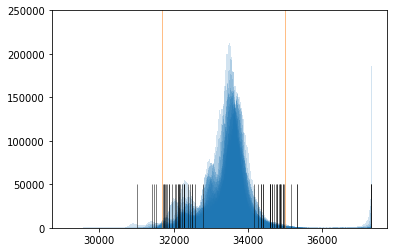

In [9]:
# Set up sampling of tile data
sample_size = 30
sample = tile_data['lil_EM'].sample(n=sample_size)
mins = []
maxs = []

# Initialize plot
fig, ax = plt.subplots()

for i, tile in sample.iterrows():

    # Load image and get intensity range
    img = imread(tile['imageUrl'])
    min_, max_ = get_intensity_range(img, outliers=1)
    mins.append(min_)
    maxs.append(max_)
    
    # Plot histogram of each image plus little marks showing each images min and max values
    ax.hist(img.flat, bins=256, histtype='bar', alpha=0.2, color='C0')
    ax.vlines(x=min_, ymin=0, ymax=50000, color='k', alpha=0.5, lw=1)
    ax.vlines(x=max_, ymin=0, ymax=50000, color='k', alpha=0.5, lw=1)

# Compute min and max intensity from rounded 20-80% distribution
min_intensity = np.around(np.percentile(mins, 20), -2)
max_intensity = np.around(np.percentile(maxs, 80), -2)

# Plot computed min and max intensity values (in orange)
ax.axvline(x=min_intensity, color='C1', alpha=0.5, lw=1);
ax.axvline(x=max_intensity, color='C1', alpha=0.5, lw=1);
ax.set_ylim(0, 250000);

# Add min and max intensity to tile data
tile_data['lil_EM']['minint'] = min_intensity
tile_data['lil_EM']['maxint'] = max_intensity
tile_data['lil_EM'][['tileId', 'acqTime', 'stageX', 'stageY', 'minint', 'maxint']].head()

#### Big Tiles
We do not need to randomly sample the big image tiles (the FM tiles and the big EM tile) because there are just one of each in the sample dataset. However, for a large dataset you could employ the same heuristic shown for the lil EM tiles. Also because each stack will be given its own intensity range. So we will just go with the min and max range excluding 1% of outliers.

/home/rlane/miniconda/envs/icat/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1834: UserWarning: ome-xml: index out of range
  warnings.warn("ome-xml: index out of range")


,tileId,acqTime,stageX,stageY,minint,maxint
0,aaa_amylase-00000x00000,2018-04-29 12:46:04,0.000,0.000,1703.0,6082.0
0,aaa_big_EM-00000x00000,2018-04-29 12:46:04,0.000,0.000,30646.0,32118.0
0,aaa_hoechst-00000x00000,2018-04-29 12:46:04,0.000,0.000,2488.0,14307.0
0,aaa_insulin-00000x00000,2018-04-29 12:46:04,0.000,0.000,1233.0,3764.0
0,aaa_lil_EM-00000x00005,2018-04-29 19:05:11,0.367,-44.661,31700.0,35000.0


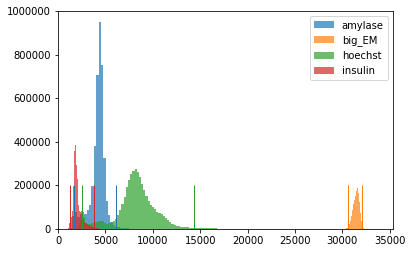

In [10]:
mins = []
maxs = []

# Initialize plot
fig, ax = plt.subplots()

for i, stack in enumerate(stacks):
    # Skip over little EM stack
    if stack != 'lil_EM':
    
        # Load image and get intensity range
        img = imread(tile_data[stack]['imageUrl'][0])
        min_intensity, max_intensity = get_intensity_range(img, outliers=1)
        tile_data[stack]['minint'] = min_intensity
        tile_data[stack]['maxint'] = max_intensity
        mins.append(min_intensity)
        maxs.append(max_intensity)
        
        # Plot histogram of each image plus little marks showing each images min and max values
        ax.hist(img.flat, bins=256, color=f'C{i}', histtype='bar', alpha=0.7, label=stack)
        ax.vlines(x=min_intensity, ymin=0, color=f'C{i}', ymax=200000, alpha=1, lw=1)
        ax.vlines(x=max_intensity, ymin=0, color=f'C{i}', ymax=200000, alpha=1, lw=1)
        
# Add legend and set x limit on the plot
ax.legend();
ax.set_xlim(0, np.max(maxs)*1.1);

# Display min and max intensity levels for each stack
pd.concat([tile_data[stack] for stack in stacks])[[
    'tileId', 'acqTime', 'stageX', 'stageY', 'minint', 'maxint']].head()

## 3 Import to Render
---
Up until now, we have yet to involve `render-ws` in any way. We have only worked on building up a table of data about our image stacks and tiles. Now that we have such a table, importing this data into `render` is easy-peasy.

### 3.1 Initialize render and Create (empty) Stacks

In [11]:
# Create a renderapi.connect.Render object
render_connect_params = {
    'host': 'sonic',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)

for stack in stacks:
    renderapi.stack.create_stack(stack, render=render)

### 3.2 Import Tile Specifications

In [12]:
tile_specs = {}

for stack in stacks:
    tile_specs[stack] = []
    print(f'Importing {stack} tile specifications to render...')

    for i, tile in tile_data[stack].iterrows():
        ts = TileSpec(**tile_data[stack].loc[i].to_dict())
        tile_specs[stack].append(ts)
        
    # Import TileSpecs to render
    renderapi.client.import_tilespecs(stack,
                                      tile_specs[stack],
                                      close_stack=True,
                                      render=render)

    # Set stack state to complete
    renderapi.stack.set_stack_state(stack, 'COMPLETE', render=render)
    
print('Tile specifications imported successfully.')

Importing amylase tile specifications to render...
Importing big_EM tile specifications to render...
Importing hoechst tile specifications to render...
Importing insulin tile specifications to render...
Importing lil_EM tile specifications to render...
Tile specifications imported successfully.
